In [1]:
import zipfile
from matplotlib import pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [541]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!wget -O Sherlock.txt https://www.gutenberg.org/ebooks/48320.txt.utf-8
!unzip wiki-news-300d-1M.vec.zip

--2023-10-27 05:12:07--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.238.206, 99.84.238.162, 99.84.238.154, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.238.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  15.0MB/s    in 39s     

2023-10-27 05:12:47 (16.7 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

unzip:  cannot find or open wiki-news-300d-1M.zip, wiki-news-300d-1M.zip.zip or wiki-news-300d-1M.zip.ZIP.


In [532]:
with open("Sherlock.txt", 'r', encoding='utf-8') as file:
    book = file.read()

In [533]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|no|No)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = ['<SOS> ' + s.strip() + ' <EOS>' for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

In [534]:
book = split_into_sentences(book)

In [361]:
book[1000:1002]

['<SOS> I had come to the conclusion that he had dropped asleep, and indeed was nodding myself, when he suddenly sprang out of his chair with the gesture of a man who has made up his mind, and put his pipe down upon the mantel-piece. <EOS>',
 '<SOS> “Sarasate plays at the St. James’s Hall this afternoon,” he remarked. <EOS>']

In [535]:
maxTokens = 500
token = Tokenizer(num_words=maxTokens,
                  filters='!"“”#$%&()*+,.-/:;=?@[\\]^_`{|}~\t\n\ufeff\u2002', lower=True,
                  split=' ', char_level=False, oov_token=None)
token.fit_on_texts(book)

In [536]:
sequences = token.texts_to_sequences(book)

In [364]:
maxLen = len(max(sequences, key=len))

In [537]:
def create_dataset(sequence):
    inputs = []
    outputs = []
    for i, sent in enumerate(sequence):
        for j in range(1, len(sent)-1):
          inputs.append(sent[:j])
          outputs.append([sent[j]])

    return inputs, outputs

In [538]:
X, y = create_dataset(sequences)
x_train = pad_sequences(X, maxlen=maxLen)
y_train = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [510]:
token.sequences_to_texts([X[20]])

['<sos> adventure of the the gentleman in the it up to her a man entered the door was and all he sat in the sherlock holmes her about him like a in a they found the the us the ’ i cried ‘you are too at the of the stairs she met this']

In [553]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])
num_words=len(dictionary)+1

In [544]:
import codecs
import IPython.display as ipd
from IPython.display import Audio, update_display
from ipywidgets import IntProgress

#EMB = "crawl-300d-2M.vec"
EMB = "wiki-news-300d-1M.vec"
N = 1000000

#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(f'./{EMB}', encoding='utf-8')
bar = IntProgress(min=0, max=N)
ipd.display(bar)

i = 0
for n, line in enumerate(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    if n//(N//100) > i:
          bar.value = n
          i += 1
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


IntProgress(value=0, max=1000000)

found 999995 word vectors


In [554]:
embed_dim=300
embedding_matrix=np.zeros([num_words, embed_dim])
for word, idx in dictionary.items():
  if word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

In [555]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, Reshape, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

nb_words = len(embedding_matrix) #Vocabulary size
embed_dim = len(embedding_matrix[0]) #Vectorization dim
value_dim = 100
maxLen = len(x_train[0])

In [556]:
input_layer = Input(shape=(maxLen,)) #Cantidad maxima de la frase de entrada, estos son los timesteps para este caso
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True)(input_layer)
lstm_out = LSTM(value_dim, return_sequences=False, activation="tanh")(embedding_layer)
dense2 = Dense(nb_words, activation='softmax')(lstm_out)
model = Model(input_layer, dense2)

In [549]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 94)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 94, 300)           2652900   
                                                                 
 lstm_11 (LSTM)              (None, 100)               160400    
                                                                 
 dense_11 (Dense)            (None, 8843)              893143    
                                                                 
Total params: 3706443 (14.14 MB)
Trainable params: 3706443 (14.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [557]:
callbackROP = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
callbackES = EarlyStopping(monitor='val_loss', patience=10)

In [558]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam')

In [560]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50, callbacks=[callbackROP, callbackES])

Epoch 1/50
114/114 [==============================] - 11s 97ms/step - loss: 5.2693 - val_loss: 5.1044 - lr: 0.0010
Epoch 2/50
114/114 [==============================] - 6s 49ms/step - loss: 5.0868 - val_loss: 5.0963 - lr: 0.0010
Epoch 3/50
114/114 [==============================] - 4s 38ms/step - loss: 5.0748 - val_loss: 5.0609 - lr: 0.0010
Epoch 4/50
114/114 [==============================] - 4s 35ms/step - loss: 4.9962 - val_loss: 4.9536 - lr: 0.0010
Epoch 5/50
114/114 [==============================] - 4s 34ms/step - loss: 4.8849 - val_loss: 4.8396 - lr: 0.0010
Epoch 6/50
114/114 [==============================] - 4s 38ms/step - loss: 4.7629 - val_loss: 4.7203 - lr: 0.0010
Epoch 7/50
114/114 [==============================] - 5s 41ms/step - loss: 4.6498 - val_loss: 4.6133 - lr: 0.0010
Epoch 8/50
114/114 [==============================] - 4s 35ms/step - loss: 4.5482 - val_loss: 4.5337 - lr: 0.0010
Epoch 9/50
114/114 [==============================] - 4s 38ms/step - loss: 4.4747 - val

# Greedy search + T

In [561]:
def changeTemp(a, temperature=1.0, epsilon=1e-10):
    a = np.log(a) / temperature
    sampled_temp = np.exp(a)/(np.exp(a).sum())
    sampled_temp = sampled_temp/sampled_temp.sum()
    return sampled_temp

def greedy_search_withT(question, T):

  out = 0
  response = []
  reply = question
  finished = False

  while out != token.texts_to_sequences(["<eos>"])[0][0] and not finished:
      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      temp = changeTemp(out[0], temperature=T)
      out = np.random.choice(range(len(temp)), p=temp)
      reply = [[out]]
      if out in response:
        finished = True
      else:
        response.append(out)

  return response

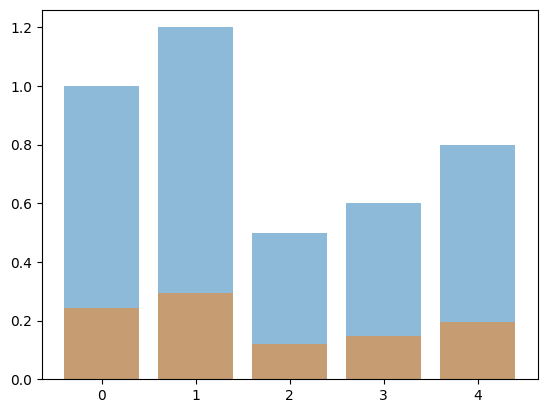

In [442]:
arr1 = [1,1.2,0.5,0.6,0.8]
plt.figure()
plt.bar(range(len(arr1)), arr1, alpha=0.5)
arr2 = changeTemp(arr1, temperature=1.0)
plt.bar(range(len(arr2)), arr2, alpha=0.5)
plt.show()

In [576]:
question = token.texts_to_sequences(["<sos> the case"])

In [579]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search_withT(question, T=1.2)
rta = from_seq_to_text(response)
rta

['it something since yourself from all then that']

# Stochastic beam search + T

In [528]:
def beam_search(kBeams, maxOutputLen, candidates):

  if maxOutputLen < 1:
    return [[]]*kBeams, [1]*kBeams
  else:
    for curr in candidates:
      out = pad_sequences([curr], maxlen=maxLen)
      out = model.predict(out, verbose=0) #Probabilidades
      newCandidates = np.argsort(out[0])[::-1][:kBeams] #Agarramos los indices de los k-elementos con mas prob
      newCandProba = [out[0][i] for i in newCandidates] #Agarramos su probabilidad
      newCandidates = [[num] for num in newCandidates] #Convertimos los numeros en listas de numeros por compatibilidad con pad_sequences

      print(newCandProba)
      print(newCandidates)

    return np.concatenate((newCandidates, beam_search(kBeams, maxOutputLen-1, newCandidates)[0]), axis=1), np.multiply(newCandProba,  beam_search(kBeams, maxOutputLen-1, newCandidates)[1])

In [529]:
question = token.texts_to_sequences(["<sos> sherlock holmes"])

In [530]:
token.sequences_to_texts([[15]])

['his']

In [531]:
maxOutputLen = 2
kBeams = 2
candidates = question

outSeq, outProb = beam_search(kBeams, maxOutputLen, candidates)
result = token.sequences_to_texts(outSeq)

for i, sent in enumerate(result):
  print(f"prob: {outProb[i]:.2f} - Rta: {sent}")

[0.9992136, 1.3436535e-07]
[[2], [1659]]
[0.9991141, 1.5084032e-07]
[[2], [1659]]
[0.9991505, 1.4481573e-07]
[[2], [1659]]
[0.9991141, 1.5084032e-07]
[[2], [1659]]
[0.9991505, 1.4481573e-07]
[[2], [1659]]
prob: 1.00 - Rta: <eos> <eos>
prob: 0.00 - Rta: 
